## 1. Visualise probing F1s

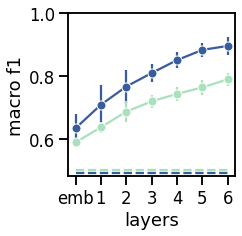

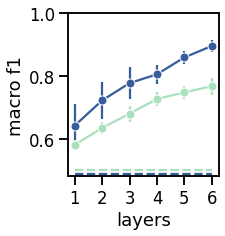

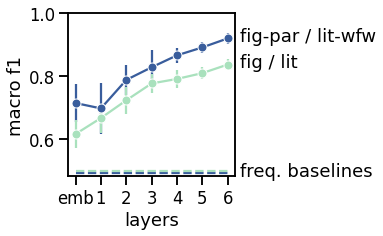

In [1]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

for setup, average_pie in [("hidden", False), ("attention", False), ("hidden", True)]:
    if setup == "attention":
        plt.figure(figsize=(2.7, 3))
        layers = [0, 1, 2, 3, 4, 5]
        xticklabels = [1, 2, 3, 4, 5, 6]
    else:
        plt.figure(figsize=(3, 3))
        layers = [0, 1, 2, 3, 4, 5, 6]
        xticklabels = ["emb", 1, 2, 3, 4, 5, 6]
    colours = sns.color_palette("mako", 9)

    data = pickle.load(open(f"data/f1s_setup={setup}_target=both_average={average_pie}.pickle", 'rb'))
    ax = sns.scatterplot(x=layers, y=[np.mean(data[l]["f1_test"]) for l in layers],
                         color=colours[3], linewidth=1, label="fig / lit")
    plt.errorbar(layers, [np.mean(data[l]["f1_test"]) for l in layers],
                 yerr=[np.std(data[l]["f1_test"]) for l in layers], color=colours[3], zorder=-1)
    sns.lineplot(x=layers, y=[np.mean([np.mean(data[l]["f1_baseline"]) for l in layers])] * (7 \
                              if setup == "hidden" else 6),
                 color=colours[3], alpha=1, zorder=-1, linestyle='--')

    data = pickle.load(open(f"data/f1s_setup={setup}_target=magpie_average={average_pie}.pickle", 'rb'))
    ax = sns.scatterplot(x=layers, y=[np.mean(data[l]["f1_test"]) for l in layers],
                         color=colours[-1], linewidth=1, label="fig-par / lit-wfw")
    plt.errorbar(layers, [np.mean(data[l]["f1_test"]) for l in layers],
                 yerr=[np.std(data[l]["f1_test"]) for l in layers], color=colours[-1], zorder=-1)
    sns.lineplot(x=layers, y=[np.mean([np.mean(data[l]["f1_baseline"]) for l in layers])] * (7 \
                              if setup == "hidden" else 6),
                 color=colours[-1], alpha=1, zorder=-1, linestyle='--')

    if setup == "hidden" and average_pie:
        plt.text(6.5, 0.83, "fig / lit")
        plt.text(6.5, 0.91, "fig-par / lit-wfw")
        plt.text(6.5, 0.48, "freq. baselines")

    ax.set_xticks(layers)
    ax.set_xticklabels(xticklabels)

    plt.ylabel("macro f1")
    plt.xlabel("layers")

    plt.ylim(0.48, 1)
    plt.legend([],[],frameon=False)
    plt.savefig(f"figures/probing_setup={setup}_average={average_pie}.pdf", bbox_inches="tight")
    plt.show()

## 2. Visualise attention from before and after intervention

In [134]:
import pickle
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

attention = pickle.load(open("attention_weights/hidden.pickle", 'rb'))

In [135]:
x, y, hue = [], [], []
for setup in [("paraphrase", "word-by-word"), ("paraphrase", "paraphrase")]:
    difference = []
    for before, after, noun_pie_indices, context_pie_indices, all_pie_indices, all_context_indices, _,_ in attention[setup]:
        before = torch.FloatTensor(before)
        after = torch.FloatTensor(after)
            
        all_pie_indices = [x for x in all_pie_indices if x not in noun_pie_indices]
        before = torch.index_select(before, dim=-2, index=torch.LongTensor(all_pie_indices))
        before = torch.mean(torch.index_select(before, dim=-1, index=torch.LongTensor(noun_pie_indices)))

        after = torch.index_select(after, dim=-2, index=torch.LongTensor(all_pie_indices))
        after = torch.mean(torch.index_select(after, dim=-1, index=torch.LongTensor(noun_pie_indices)))
        difference.append((after.item() - before.item()) / before.item() * 100)

    x.extend([0 for _ in difference])
    y.extend(difference)
    hue.extend(["pie-pie" for _ in difference])

    difference = []
    for before, after, noun_pie_indices, noun_context_indices, all_pie_indices, all_context_indices, _,_ in attention[setup]:
        before = torch.FloatTensor(before)
        after = torch.FloatTensor(after)
            
        all_pie_indices = [x for x in all_pie_indices if x not in noun_pie_indices]
        before = torch.index_select(before, dim=-2, index=torch.LongTensor(all_pie_indices))
        before = torch.mean(torch.index_select(before, dim=-1, index=torch.LongTensor(noun_context_indices)))

        after = torch.index_select(after, dim=-2, index=torch.LongTensor(all_pie_indices))
        after = torch.mean(torch.index_select(after, dim=-1, index=torch.LongTensor(noun_context_indices)))
        difference.append((after.item() - before.item())/before.item() * 100)

    x.extend([0 for _ in difference])
    y.extend(difference)
    hue.extend(["pie-context" for _ in difference])

    difference = []
    for before, after, noun_pie_indices, noun_context_indices, all_pie_indices, all_context_indices, _,_ in attention[setup]:
        before = torch.FloatTensor(before)
        after = torch.FloatTensor(after)
            
        all_pie_indices = [x for x in all_pie_indices if x not in noun_pie_indices]
        before = torch.index_select(before, dim=-2, index=torch.LongTensor(all_context_indices))
        before = torch.mean(torch.index_select(before, dim=-1, index=torch.LongTensor(noun_pie_indices)))

        after = torch.index_select(after, dim=-2, index=torch.LongTensor(all_context_indices))
        after = torch.mean(torch.index_select(after, dim=-1, index=torch.LongTensor(noun_pie_indices)))
        difference.append((after.item() - before.item()) / before.item() * 100)

    x.extend([0 for _ in difference])
    y.extend(difference)
    hue.extend(["context-pie" for _ in difference])

c:\users\gebruiker\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\gebruiker\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


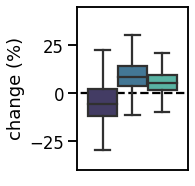

In [137]:
plt.figure(figsize=(2, 3))
ax = sns.boxplot(x, y, hue=hue, palette="mako", fliersize=0)
plt.ylabel("change (%)")
plt.ylim(-40, 45)
plt.xlim(-0.5, 0.5)
ax = sns.lineplot([-1, 1], [0, 0], color="black", linestyle="--", zorder=-1)
plt.legend([], [], frameon=False) #bbox_to_anchor=(1, 1.05), frameon=False)
ax.set_xticks([])
plt.savefig("inlp_attention_hidden.pdf", bbox_inches="tight")
#plt.ylabel("")

In [12]:
def generate(model,
             tokenizer,
             sentence,
             attention_projection_indices=None,
             attention_projection_matrices=[None]*7,
             hidden_projection_indices=None,
             hidden_projection_matrices=[None]*7):

    # Preprocess the input by Transformer's MarianMT tokeniser
    batch = tokenizer.prepare_seq2seq_batch(src_texts=[sentence], return_tensors="pt")

    # Generate a regular translation
    decoder_outputs = model.generate(
        **batch, beam_size=5, return_dict_in_generate=True,
        attention_projection_indices=attention_projection_indices,
        attention_projection_matrix=attention_projection_matrices,
        hidden_projection_matrix=hidden_projection_matrices,
        hidden_projection_indices=hidden_projection_indices)

    tgt_tokens = tokenizer.convert_ids_to_tokens(decoder_outputs["sequences"][0])
    tgt = "".join(tgt_tokens[1:-1]).replace("▁", " ").strip()
    return tgt


def tokenise(sentence, annotation):
    tok_sent, tok_annotations = [], []
    for w, l in zip(sentence.split(), annotation):
        tokenised_w = tokenizer.tokenize(w)
        tok_sent.extend(tokenised_w)
        tok_annotations.extend([l] * len(tokenised_w))
    return tok_annotations

In [55]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pickle

# Load the MarianMT model
model_version = 'Helsinki-NLP/opus-mt-en-nl'
model = AutoModelForSeq2SeqLM.from_pretrained(model_version)
tokenizer = AutoTokenizer.from_pretrained(model_version)
model.eval()

# Remember that when trying any sentence with any idiom, the model
# is most likely to emit a word for word translation, so it is very hard
# to find a paraphrase by simply trying.
# Here are 10 examples of idioms the model can paraphrase, although
# it doesn't happen in every context containing the idiom.

data = [
    ("Most seven year olds sleep for about ten hours at a stretch.",
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]),
    ("And so it is right across the board.",
     [0, 0, 0, 0, 0, 1, 0, 1]),
    ("Restored in 1960 for the Temora Aero Club she eventually fell into disuse and was sold to Ray Windred of Dungong, New South Wales, as a basket case.",
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]),
    ("I won't beat about the bush.",
     [0, 0, 0, 1, 0, 1]),
    ("Such a clause would not bring the dispute between holists and individualists any nearer to a solution, however, since it begs the very question at issue.",
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]),
    ("Bearing those points in mind one seven eight offers a better way forward to use the skills and experience of our lay officials and members.",
     [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    ("As a general rule, it's simple to criticize, but difficult to produce alternative suggestions.",
     [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    ("You should have at your fingertips some basic methods of handling conflict in meetings since it is almost inevitable and occasionally healthy.",
     [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    ("Mrs Thatcher sees nothing in the single market which cuts against the grain of her policies over the past decade, since it should promote the free enterprise culture within the EC.",
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
]


hidden_projection_matrices = []
attention_projection_matrices = []
for layer in range(7):
    P = pickle.load(open(f"projection_matrices/hidden_fold=0_layer={layer}_baseline=False_classifiers=50.pickle", 'rb'))
    hidden_projection_matrices.append(P)
    if layer != 0:
        P = pickle.load(open(f"projection_matrices/attention_fold=0_layer={layer}_baseline=False_classifiers=50.pickle", 'rb'))
        attention_projection_matrices.append(P)
    else:
        # There is no layer 0 for the attention, layer 0 are the embeddings
        attention_projection_matrices.append(P)

pie_indices = [i for i, l in enumerate(tokenise(sentence, annotation)) if l == 1]

translation_before = generate(model, tokenizer, sentence)
print(translation_before)
translation_after = generate(
    model, tokenizer, sentence,
    attention_projection_indices=pie_indices,
    attention_projection_matrices=attention_projection_matrices,
    hidden_projection_indices=pie_indices,
    hidden_projection_matrices=hidden_projection_matrices)
print(translation_after)

Mevrouw Thatcher ziet niets in de interne markt die in de afgelopen tien jaar tegen de kern van haar beleid ingaat, aangezien zij de vrije ondernemingscultuur binnen de EG zou moeten bevorderen.
Mevrouw Thatcher ziet niets in de interne markt die in de afgelopen tien jaar tegen de graankorrel van haar beleid ingaat, aangezien zij de vrije ondernemingscultuur binnen de EG zou moeten bevorderen.


In [9]:
tokenise(sentence, annotation)

(['▁I',
  '▁suppose',
  '▁you',
  "▁'",
  're',
  '▁ahead',
  '▁of',
  '▁the',
  '▁game',
  '▁if',
  '▁you',
  "▁'",
  're',
  '▁alive',
  '.'],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0])